In [ ]:
# | default_exp classes.DomoUser

In [ ]:
# | export
from domolibrary.routes.user import (
    UserProperty,
    UserProperty_Type,
    GetUser_Error,
    SearchUser_NoResults,
    User_CrudError,
    ResetPassword_PasswordUsed,
    DownloadAvatar_Error,
)

In [ ]:
# | exporti

import datetime as dt
from dataclasses import dataclass, field
from typing import Optional
import httpx

from nbdev.showdoc import patch_to

from pprint import pprint

import domolibrary.utils.DictDot as util_dd
from domolibrary.utils.convert import test_valid_email

import domolibrary.client.DomoAuth as dmda
import domolibrary.client.Logger as lc
import domolibrary.client.DomoError as de
import domolibrary.routes.user as user_routes

In [ ]:
# | hide
import os
import pandas as pd
import datetime as dt

import domolibrary.routes.bootstrap as bootstrap_routes

from pprint import pprint


from nbdev.showdoc import show_doc

In [ ]:
# | hide
from PIL import Image
from IPython.display import display
import io

# Class Errors

In [ ]:
# | export
class CreateUser_MissingRole(de.DomoError):
    def __init__(self, domo_instance, email_address):
        super().__init__(
            domo_instance=domo_instance,
            message=f"error creating user {email_address} missing role_id",
        )


class DeleteUser_Error(de.DomoError):
    def __init__(self, domo_instance, email_address):
        super().__init__(
            domo_instance=domo_instance,
            message=f"error deleting user {email_address}.",
        )


class DownloadAvatar_NoAvatarKey(de.DomoError):
    def __init__(
        self,
        domo_instance,
        user_id,
    ):
        super().__init__(
            domo_instance,
            message=f"This profile {user_id} doesn't have an avatar uploaded - unable to download",
        )

# MAIN -- Domo User


In [ ]:
# | export
@dataclass
class DomoUser:
    """a class for interacting with a Domo User"""

    id: str
    display_name: str = None
    email_address: str = None
    role_id: str = None
    department: str = None
    title: str = None
    avatar_key: str = None

    phone_number: str = None
    web_landing_page: str = None
    web_mobile_landing_page: str = None
    employee_id: str = None
    employee_number: str = None
    hire_date: str = None
    reports_to: str = None

    publisher_domain: str = None
    subscriber_domain: str = None
    virtual_user_id: str = None

    custom_attributes: dict = field(default_factory=dict)

    role: dict = None  # DomoRole

    auth: Optional[dmda.DomoAuth] = field(repr=False, default=None)

    def __post_init__(self):
        self.id = str(self.id)

    def __eq__(self, other):
        if not isinstance(other, DomoUser):
            return False

        return self.id == other.id

    @classmethod
    def _from_search_json(cls, auth, user_obj):
        user_dd = util_dd.DictDot(user_obj)

        return cls(
            auth=auth,
            id=str(user_dd.id or user_dd.userId),
            display_name=user_dd.displayName,
            title=user_dd.title,
            department=user_dd.department,
            email_address=user_dd.emailAddress or user_dd.email,
            role_id=user_dd.roleId,
            avatar_key=user_dd.avatarKey,
            phone_number=user_dd.phoneNumber,
            web_landing_page=user_dd.webLandingPage,
            web_mobile_landing_page=user_dd.webMobileLandingPage,
            employee_id=user_dd.employeeId,
            employee_number=user_dd.employeeNumber,
            hire_date=user_dd.hireDate,
            reports_to=user_dd.reportsTo,
        )

    @classmethod
    def _from_virtual_json(cls, auth, user_obj):
        user_dd = util_dd.DictDot(user_obj)

        return cls(
            id=user_dd.id,
            auth=auth,
            publisher_domain=user_dd.publisherDomain,
            subscriber_domain=user_dd.subscriberDomain,
            virtual_user_id=user_dd.virtualUserId,
        )

    @classmethod
    def _from_bootstrap_json(cls, auth, user_obj):
        dd = user_obj
        if isinstance(user_obj, dict):
            dd = util_dd.DictDot(user_obj)

        return cls(id=dd.id, display_name=dd.displayName, auth=auth)

In [ ]:
# | hide

# import domolibrary.routes.bootstrap as bootstrap_routes


auth = dmda.DomoFullAuth(
    domo_instance="domo-community",
    domo_password=os.environ["DOJO_PASSWORD"],
    domo_username=os.environ["DOMO_USERNAME"],
)

res = await bootstrap_routes.get_bootstrap_pages(auth=auth)

page_obj = res.response[10]
owners_ls = page_obj.get("owners")

DomoUser._from_bootstrap_json(auth=auth, user_obj=owners_ls[0])

DomoUser(id='1345408759', display_name='Alexis Lorenz (DataMaven)', email_address=None, role_id=None, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=None)

In [ ]:
# | exporti
@patch_to(DomoUser)
async def get_role(
    self: DomoUser,
    return_raw: bool = False,
    debug_api: bool = False,
    debug_num_stacks_to_drop=2,
    session: httpx.AsyncClient = None,
):
    import domolibrary.classes.DomoRole as dmr

    self.role = await dmr.DomoRole.get_by_id(
        role_id=self.role_id,
        auth=self.auth,
        debug_api=debug_api,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        session=session,
    )

    return self.role

In [ ]:
# | exporti
@patch_to(DomoUser, cls_method=True)
async def get_by_id(
    cls: DomoUser,
    user_id,
    auth: dmda.DomoAuth,
    return_raw: bool = False,
    debug_api: bool = False,
    debug_num_stacks_to_drop=2,
    session: httpx.AsyncClient = None,
):
    """
    searches and returns a domo user
    will throw an error if no user returned with an option to suppress_no_results_error
    """

    res = await user_routes.get_by_id(
        auth=auth,
        user_id=user_id,
        debug_api=debug_api,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        session=session,
        parent_class=cls.__name__,
    )

    if return_raw:
        return res

    if not res.is_success:
        return None

    domo_user = cls._from_search_json(user_obj=res.response, auth=auth)

    await domo_user.get_role()

    return domo_user

In [ ]:
show_doc(DomoUser.get_by_id)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L168){target="_blank" style="float:right; font-size:smaller"}

### DomoUser.get_by_id

>      DomoUser.get_by_id (user_id, auth:domolibrary.client.DomoAuth.DomoAuth,
>                          return_raw:bool=False, debug_api:bool=False,
>                          debug_num_stacks_to_drop=2,
>                          session:httpx.AsyncClient=None)

searches and returns a domo user
will throw an error if no user returned with an option to suppress_no_results_error

#### sample implementation of get_by_id


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)
user_id = os.environ["DOMO_DOJO_USER_ID"]

pprint(await DomoUser.get_by_id(user_id=user_id, auth=token_auth, return_raw=False))

DomoUser(id='663516735',
         display_name='test 3',
         email_address='test33@test.com',
         role_id=810756122,
         department=None,
         title=None,
         avatar_key=None,
         phone_number=None,
         web_landing_page=None,
         web_mobile_landing_page=None,
         employee_id=None,
         employee_number=None,
         hire_date=None,
         reports_to=None,
         publisher_domain=None,
         subscriber_domain=None,
         virtual_user_id=None,
         custom_attributes={},
         role=DomoRole(id=810756122,
                       name='super_admin',
                       description='updated via domolibrary on 2024-02-15',
                       is_system_role=0,
                       is_default_role=None,
                       grant_ls=[],
                       membership_ls=[]))


In [ ]:
# | exporti
@patch_to(DomoUser)
async def download_avatar(
    self: DomoUser,
    pixels: int = 300,
    folder_path="./images",
    img_name=None,  # will default to user_id
    auth: dmda.DomoAuth = None,
    is_download_image: bool = True,  # option to prevent downloading the image file
    debug_api: bool = False,
    return_raw: bool = False,
):
    """downloads a user's avatar to a folder
    and returns the byte representation of the image
    """
    auth = auth or self.auth

    if not self.avatar_key:
        raise DownloadAvatar_NoAvatarKey(
            domo_instance=auth.domo_instance, user_id=self.id
        )

    res = await user_routes.download_avatar(
        auth=self.auth,
        user_id=self.id,
        pixels=pixels,
        folder_path=folder_path,
        img_name=img_name,
        is_download_image=is_download_image,
        debug_api=debug_api,
    )

    if return_raw:
        return res

    return res.response

In [ ]:
show_doc(DomoUser.download_avatar)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L205){target="_blank" style="float:right; font-size:smaller"}

### DomoUser.download_avatar

>      DomoUser.download_avatar (pixels:int=300, folder_path='./images',
>                                img_name=None,
>                                auth:domolibrary.client.DomoAuth.DomoAuth=None,
>                                is_download_image:bool=True,
>                                debug_api:bool=False, return_raw:bool=False)

downloads a user's avatar to a folder
and returns the byte representation of the image

#### sample download_avatar


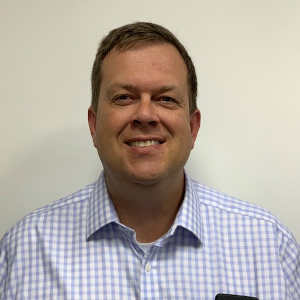

In [ ]:
# from PIL import Image
# from IPython.display import display
# import io

token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

user_id = 1833256765

domo_user = await DomoUser.get_by_id(user_id=user_id, auth=token_auth)

image = await domo_user.download_avatar(
    folder_path="../test/", img_name="cls_sample.png"
)
img = Image.open(io.BytesIO(image))
display(img)

In [ ]:
# | exporti
@patch_to(DomoUser)
async def reset_password(self: DomoUser, new_password: str, debug_api: bool = False):
    """reset your password, will respect password restrictions set up in the Domo UI"""

    res = await user_routes.reset_password(
        auth=self.auth, user_id=self.id, new_password=new_password, debug_api=debug_api
    )

    return res

In [ ]:
show_doc(DomoUser.reset_password)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L242){target="_blank" style="float:right; font-size:smaller"}

### DomoUser.reset_password

>      DomoUser.reset_password (new_password:str, debug_api:bool=False)

reset your password, will respect password restrictions set up in the Domo UI

In [ ]:
# | exporti
@patch_to(DomoUser, cls_method=True)
async def request_password_reset(
    cls,
    domo_instance: str,
    email: str,
    locale: str = "en-us",
    debug_api: bool = False,
    session: httpx.AsyncClient = None,
):
    """request password reset email.  Note: does not require authentication."""

    return await user_routes.request_password_reset(
        domo_instance=domo_instance,
        email=email,
        locale=locale,
        debug_api=debug_api,
        session=session,
    )

In [ ]:
# | exporti
@patch_to(DomoUser)
async def set_user_landing_page(
    self: DomoUser,
    page_id: str,
    user_id: str = None,
    auth: dmda.DomoAuth = None,
    debug_api: bool = False,
):
    res = await user_routes.set_user_landing_page(
        auth=auth or self.auth,
        page_id=page_id,
        user_id=self.id or user_id,
        debug_api=debug_api,
    )

    if res.status != 200:
        return False

    return True

In [ ]:
show_doc(DomoUser.set_user_landing_page)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L273){target="_blank" style="float:right; font-size:smaller"}

### DomoUser.set_user_landing_page

>      DomoUser.set_user_landing_page (page_id:str, user_id:str=None,
>                                      auth:domolibrary.client.DomoAuth.DomoAuth
>                                      =None, debug_api:bool=False)

In [ ]:
# | exporti
@patch_to(DomoUser)
async def update_properties(
    self: DomoUser,
    property_ls: [
        UserProperty
    ],  # use the UserProperty class to define a list of user properties to update, see user route documentation to see a list of UserProperty_Types that can be updated
    return_raw: bool = False,
    auth: dmda.DomoAuth = None,
    debug_api: bool = False,
    session: httpx.AsyncClient = None,
):
    auth = auth or self.auth

    res = await user_routes.update_user(
        auth=auth,
        user_id=self.id,
        user_property_ls=property_ls,
        debug_api=debug_api,
        session=session,
    )
    if return_raw:
        return res

    self = await DomoUser.get_by_id(user_id=self.id, auth=auth)

    return self

In [ ]:
show_doc(DomoUser.update_properties)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L294){target="_blank" style="float:right; font-size:smaller"}

### DomoUser.update_properties

>      DomoUser.update_properties
>                                  (property_ls:[<class'domolibrary.routes.user.
>                                  UserProperty'>], return_raw:bool=False, auth:
>                                  domolibrary.client.DomoAuth.DomoAuth=None,
>                                  debug_api:bool=False,
>                                  session:httpx.AsyncClient=None)

#### sample update_properties


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

domo_user = await DomoUser.get_by_id(
    user_id=os.environ["DOMO_DOJO_USER_ID"], auth=token_auth
)

property_ls = [
    UserProperty(UserProperty_Type.display_name, "test 3"),
    UserProperty(UserProperty_Type.email_address, "test33@test.com"),
    UserProperty(UserProperty_Type.role_id, 810756122),
]

try:
    await domo_user.update_properties(property_ls=property_ls)
except User_CrudError as e:
    print(e)

# MAIN -- DomoUsers

> a class for searching Domo Users


In [ ]:
# | export


@dataclass
class DomoUsers:
    """a class for searching for Users"""

    logger: Optional[lc.Logger] = None

    @classmethod
    def _users_to_domo_user(cls, user_ls, auth: dmda.DomoAuth):
        return [
            DomoUser._from_search_json(auth=auth, user_obj=user_obj)
            for user_obj in user_ls
        ]

    @classmethod
    def _users_to_virtual_user(cls, user_ls, auth: dmda.DomoAuth):
        return [
            DomoUser._from_virtual_json(auth=auth, user_obj=user_obj)
            for user_obj in user_ls
        ]

    def _generate_logger(self, logger: Optional[lc.Logger] = None):
        self.logger = logger or self.logger or lc.Logger(app_name="domo_users")

## Search and GET Users


In [ ]:
# | exporti
@patch_to(DomoUsers, cls_method=True)
async def all_users(
    cls: DomoUsers,
    auth: dmda.DomoAuth,
    return_raw: bool = False,
    debug_api: bool = False,
    debug_num_stacks_to_drop=2,
    logger: Optional[lc.Logger] = None,
) -> [DomoUser]:
    """retrieves all users from Domo"""

    res = await user_routes.get_all_users(
        auth=auth,
        debug_api=debug_api,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        parent_class=cls.__name__,
    )

    if return_raw:
        return res

    if not res.is_success:
        return None

    users_ls = res.response

    return cls._users_to_domo_user(user_ls=users_ls, auth=auth)

In [ ]:
show_doc(DomoUsers.all_users)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L346){target="_blank" style="float:right; font-size:smaller"}

### DomoUsers.all_users

>      DomoUsers.all_users (auth:domolibrary.client.DomoAuth.DomoAuth,
>                           return_raw:bool=False, debug_api:bool=False,
>                           debug_num_stacks_to_drop=2, logger:Optional[domolibr
>                           ary.client.Logger.Logger]=None)

retrieves all users from Domo

#### sample implementation of get all_users


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

domo_users = await DomoUsers.all_users(
    auth=token_auth, debug_api=False, return_raw=False
)

pd.DataFrame(domo_users[0:3])

,id,display_name,email_address,role_id,department,title,avatar_key,phone_number,web_landing_page,web_mobile_landing_page,employee_id,employee_number,hire_date,reports_to,publisher_domain,subscriber_domain,virtual_user_id,custom_attributes,role,auth
0,None,monitor,monitor@domo.com,1,None,None,None,None,None,None,None,None,None,None,None,None,None,{},None,"{'domo_instance': 'domo-community', 'domo_acce..."
1,1003855998,Christine Hsieh,christine.hsieh@hellofresh.com,2,None,None,None,None,None,None,None,None,None,None,None,None,None,{},None,"{'domo_instance': 'domo-community', 'domo_acce..."
2,1005321923,Matthew Lambourne,matthew.lambourne@frankandoak.com,2,None,Financial Controller,None,None,None,None,None,None,None,None,None,None,None,{},None,"{'domo_instance': 'domo-community', 'domo_acce..."


In [ ]:
# | exporti
@patch_to(DomoUsers, cls_method=True)
async def by_id(
    cls: DomoUsers,
    auth: dmda.DomoAuth,
    user_ids: list[str],  # can search for one or multiple users
    only_allow_one: bool = True,
    debug_num_stacks_to_drop=2,
    debug_api: bool = False,
    return_raw: bool = False,
) -> list:

    res = await user_routes.search_users_by_id(
        return_raw=False,
        user_ids=user_ids,
        debug_api=debug_api,
        auth=auth,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        parent_class=cls.__name__,
    )

    if return_raw:
        return res

    domo_users = cls._users_to_domo_user(user_ls=res.response, auth=auth)

    if only_allow_one:
        return domo_users[0]

    return domo_users

#### sample implementation of searching users by_id


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

await DomoUsers.by_id(
    auth=token_auth,
    user_ids=["1006847540", "1012895591"],
    only_allow_one=False,
    return_raw=False,
)

[DomoUser(id='1012895591', display_name='JeMiller', email_address='JeMiller@marketaxess.com', role_id=2097317660, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=None),
 DomoUser(id='1006847540', display_name='Marc-Anton Clavel', email_address='marcanton.clavel@domo.com', role_id=2, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=None)]

In [ ]:
# | exporti


@patch_to(DomoUsers, cls_method=True)
def util_match_domo_users_to_emails(
    cls: DomoUsers, domo_users: list[DomoUser], user_email_ls: list[str]
) -> list:
    """pass in an array of user emails to match against an array of Domo User"""

    matches = []
    for idx, email in enumerate(user_email_ls):
        match_user = next(
            (
                domo_user
                for domo_user in domo_users
                if email.lower() == domo_user.email_address.lower()
            ),
            None,
        )
        if match_user:
            matches.append(match_user)
    return matches


@patch_to(DomoUsers, cls_method=True)
def util_match_users_obj_to_emails(
    cls: DomoUsers, user_ls: list[dict], user_email_ls: list[str]
) -> list:
    """pass in an array of user emails to match against an array of Domo User"""

    matches = []
    for idx, email in enumerate(user_email_ls):
        match_user = next(
            (
                user_obj
                for user_obj in user_ls
                if email.lower() == user_obj.get("emailAddress").lower()
            ),
            None,
        )
        if match_user:
            matches.append(match_user)
    return matches


@patch_to(DomoUsers, cls_method=True)
async def by_email(
    cls: DomoUsers,
    email_ls: list[str],
    auth: dmda.DomoAuth,
    only_allow_one: bool = True,
    debug_api: bool = False,
    debug_num_stacks_to_drop=2,
    return_raw: bool = False,
) -> list:

    res = await user_routes.search_users_by_email(
        user_email_ls=email_ls,
        auth=auth,
        return_raw=False,
        debug_api=debug_api,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        parent_class=cls.__name__,
    )

    if return_raw:
        return res

    domo_users = cls._users_to_domo_user(res.response, auth=auth)

    if only_allow_one:
        return cls.util_match_domo_users_to_emails(domo_users, email_ls)[0]

    return domo_users

In [ ]:
show_doc(DomoUsers.by_email)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L448){target="_blank" style="float:right; font-size:smaller"}

### DomoUsers.by_email

>      DomoUsers.by_email (email_ls:list[str],
>                          auth:domolibrary.client.DomoAuth.DomoAuth,
>                          only_allow_one:bool=True, debug_api:bool=False,
>                          debug_num_stacks_to_drop=2, return_raw:bool=False)

#### sample implementation of searching for a user by email


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)


await DomoUsers.by_email(
    auth=token_auth,
    email_ls=["jae@onyxreporting.com"],
    only_allow_one=True,
    return_raw=False,
    debug_api=False,
)

DomoUser(id='1893952720', display_name='Jae Wilson1', email_address='jae@onyxreporting.com', role_id=810756122, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=None)

In [ ]:
# | exporti
@patch_to(DomoUsers, cls_method=True)
async def virtual_user_by_subscriber_instance(
    cls: DomoUsers,
    subscriber_instance_ls: str,
    auth: dmda.DomoAuth,
    debug_api: bool = False,
    return_raw: bool = False,
):
    res = await user_routes.search_virtual_user_by_subscriber_instance(
        auth=auth,
        subscriber_instance_ls=subscriber_instance_ls,
        debug_api=debug_api,
    )

    if return_raw:
        return res

    if not res.is_success:
        return None

    user_ls = res.response

    domo_users = cls._users_to_virtual_user(user_ls, auth=auth)
    return domo_users

In [ ]:
show_doc(DomoUsers.virtual_user_by_subscriber_instance)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L479){target="_blank" style="float:right; font-size:smaller"}

### DomoUsers.virtual_user_by_subscriber_instance

>      DomoUsers.virtual_user_by_subscriber_instance
>                                                     (subscriber_instance_ls:st
>                                                     r, auth:domolibrary.client
>                                                     .DomoAuth.DomoAuth,
>                                                     debug_api:bool=False,
>                                                     return_raw:bool=False)

#### sample implementation of retrieving virtual users for a subscriber instance


In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)


await DomoUsers.virtual_user_by_subscriber_instance(
    auth=token_auth,
    subscriber_instance_ls=["domo-community", "test"],
    # return_raw=True,
    debug_api=False,
)

[DomoUser(id='44a56146-f422-4175-9c3b-a194f339f9b6', display_name=None, email_address=None, role_id=None, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain='domo-community.domo.com', subscriber_domain='domo-community.domo.com', virtual_user_id='fc:f230ba95-bc49-4875-a0db-3c7cd58ed3cc', custom_attributes={}, role=None),
 DomoUser(id='8b5c26e0-db3a-40f8-855f-6189ac3cf5c8', display_name=None, email_address=None, role_id=None, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain='domo-community.domo.com', subscriber_domain='test.domo.com', virtual_user_id='fc:e3ce6205-6717-42b4-ba1c-16b5e40eca98', custom_attributes={}, role=None)]

## CRUD Users


In [ ]:
# | exporti


@patch_to(DomoUsers, cls_method=True)
async def create_user(
    cls: DomoUsers,
    auth: dmda.DomoAuth,
    display_name,
    email_address,
    role_id,
    password: str = None,
    send_password_reset_email: bool = False,
    debug_api: bool = False,
    session: httpx.AsyncClient = None,
):
    """class method that creates a new Domo user"""

    res = await user_routes.create_user(
        auth=auth,
        display_name=display_name,
        email_address=email_address,
        role_id=role_id,
        debug_api=debug_api,
        session=session,
    )

    if not res.is_success:
        raise Exception(res.response)

    u = await DomoUser.get_by_id(
        auth=auth,
        user_id=res.response.get("id") or res.response.get("userId"),
    )

    if password:
        await u.reset_password(new_password=password)

    elif send_password_reset_email:
        await u.request_password_reset(
            domo_instance=auth.domo_instance, email=u.email_address
        )

    return u

In [ ]:
show_doc(DomoUsers.create_user)

---

[source](https://github.com/jaewilson07/domo_library/blob/main/domolibrary/classes/DomoUser.py#L505){target="_blank" style="float:right; font-size:smaller"}

### DomoUsers.create_user

>      DomoUsers.create_user (auth:domolibrary.client.DomoAuth.DomoAuth,
>                             display_name, email_address, role_id,
>                             password:str=None,
>                             send_password_reset_email:bool=False,
>                             debug_api:bool=False,
>                             session:httpx.AsyncClient=None)

class method that creates a new Domo user

In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)
try:
    await DomoUsers.create_user(
        auth=token_auth,
        display_name="test_and_delete",
        email_address="test26@test.com",
        role_id=5,
    )
except User_CrudError as e:
    print(e)

🛑  User_CrudError 🛑 - function: create_user || status 400 || Bad Request - does this user (email) already exist? at domo-community


In [ ]:
# |exporti
@patch_to(DomoUsers, cls_method=True)
async def upsert_user(
    cls: DomoUsers,
    auth: dmda.DomoAuth,
    email_address: str,
    display_name: str = None,
    role_id: str = None,
    debug_api: bool = False,
    debug_prn: bool = False,
    session: httpx.AsyncClient = None,
):
    test_valid_email(email_address)

    try:
        domo_user = await cls.by_email(
            email_ls=[email_address],
            auth=auth,
            only_allow_one=True,
            debug_api=debug_api,
        )

        if domo_user:
            user_property_ls = []
            if display_name:
                user_property_ls.append(
                    user_routes.UserProperty(
                        user_routes.UserProperty_Type.display_name, display_name
                    )
                )

            if role_id:
                user_property_ls.append(
                    user_routes.UserProperty(
                        user_routes.UserProperty_Type.role_id, role_id
                    )
                )

            if user_property_ls:
                res = await user_routes.update_user(
                    user_id=domo_user.id,
                    user_property_ls=user_property_ls,
                    auth=auth,
                    debug_api=debug_api,
                )
        return await DomoUser.get_by_id(auth=auth, user_id=domo_user.id)

    except SearchUser_NoResults as e:
        if debug_prn:
            print(f"No user match -- creating new user in {auth.domo_instance}")

        if not role_id:
            raise CreateUser_MissingRole(
                domo_instance=auth.domo_instance, email_address=email_address
            ) from e

        return await cls.create_user(
            auth=auth,
            display_name=display_name or f"{email_address} - via dl {dt.date.today()}",
            email_address=email_address,
            role_id=role_id,
            debug_api=debug_api,
            session=session,
        )

    # finally:
    #     if grant_ls:
    #         grant_ls = domo_role._valid_grant_ls(grant_ls)
    #         await domo_role.set_grants(grant_ls=grant_ls)

In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

await DomoUsers.upsert_user(
    email_address="test4@test.com",
    display_name=f"test - updated via dl {dt.date.today()}",
    role_id=3,
    auth=token_auth,
    debug_prn=True,
    debug_api=False,
)

DomoUser(id='1793882853', display_name='test - updated via dl 2024-02-15', email_address='test4@test.com', role_id=3, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=DomoRole(id=3, name='Editor', description='Can edit Cards, Pages, DataSets, and Dataflows', is_system_role=True, is_default_role=None, grant_ls=[], membership_ls=[]))

In [ ]:
# | export


@patch_to(DomoUser)
async def delete_user(
    self: DomoUser,
    auth: dmda.DomoAuth = None,
    debug_api: bool = False,
    session: httpx.AsyncClient = None,
    debug_num_stacks_to_drop=2,
    parent_class=None,
):
    auth = auth or self.auth

    res = await user_routes.delete_user(
        auth=auth,
        user_id=self.id,
        debug_api=debug_api,
        session=session,
        debug_num_stacks_to_drop=debug_num_stacks_to_drop,
        parent_class=parent_class,
    )

    if not res.is_success:
        raise DeleteUser_Error(account_id=self.id, domo_instance=auth.domo_instance)

    return res

In [ ]:
token_auth = dmda.DomoTokenAuth(
    domo_instance="domo-community",
    domo_access_token=os.environ["DOMO_DOJO_ACCESS_TOKEN"],
)

dmuser = await DomoUsers.by_email(
    auth=token_auth,
    email_ls=["test4@test.com"],
    only_allow_one=True,
    return_raw=False,
    debug_api=False,
)
print(dmuser)

await dmuser.delete_user()

DomoUser(id='1793882853', display_name='test - updated via dl 2024-02-15', email_address='test4@test.com', role_id=3, department=None, title=None, avatar_key=None, phone_number=None, web_landing_page=None, web_mobile_landing_page=None, employee_id=None, employee_number=None, hire_date=None, reports_to=None, publisher_domain=None, subscriber_domain=None, virtual_user_id=None, custom_attributes={}, role=None)


ResponseGetData(status=200, response='', is_success=True, parent_class=None)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()